# Neural Predictivity

## Setup

### Install Necessary Packages

In [1]:
#pip install pytorch-lightning scikit-learn scipy lightly

### Import packages

In [2]:
import os
import torchvision
import PIL
import torch
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import tqdm
import warnings
import logging
import sklearn
import h5py as hdf
from matplotlib import pyplot as plt
from torchvision.models import alexnet
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression

In [3]:
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)

In [4]:
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
def setup_logger(name, log_file, level=logging.INFO):
    """To setup as many loggers as you want"""

    handler = logging.FileHandler(log_file)        
    handler.setFormatter(formatter)

    logger = logging.getLogger(name)
    logger.setLevel(level)
    logger.addHandler(handler)

    return logger

### Load Neural Data

### Load Stimuli

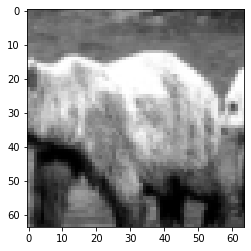

In [5]:
class NaturalScenes(torch.utils.data.Dataset):
    def __init__(self,file_path = 'DeepMouseTrap/neural_data/brain_observatory/stimulus_set.npy'):
        self.ims = np.load(file_path)
        self.size = 118
        self.transform = torchvision.transforms.Compose([torchvision.transforms.Resize([256]),torchvision.transforms.CenterCrop(224),torchvision.transforms.Resize([64,64]),torchvision.transforms.ToTensor()])
    def __len__(self):
        return self.size
    def __getitem__(self, index):
        im = PIL.Image.fromarray(self.ims[index])
        im = self.transform(im)
        im = im.unsqueeze(0)
        return im
stimulus = NaturalScenes()
train_stim,test_stim = torch.utils.data.random_split(stimulus,[int(118/2),int(118/2)])
plt.imshow(torch.permute(torch.squeeze(stimulus[0]),(1,2,0)))

In [6]:
model = alexnet(pretrained=False)
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

### Define Necessary Functions

In [7]:
def extract_model_response(model=alexnet(pretrained=False).features, stimulus = train_stim):
    LAYER_MAPPING = {2:'conv1',5:'conv2',8:'conv3',10:'conv4',12:'conv5'}
    model_activations = {layer:None for layer in LAYER_MAPPING.values()}
    for ind,layer in LAYER_MAPPING.items():
        activation_model=model[:ind] #get activation model at layer
        activation_model.eval()
        activations = []
        for j in range(len(stimulus)):
            activation = activation_model(stimulus[j]) #extract activations
            activations.append(activation.detach().numpy().squeeze().flatten())
        activations = np.stack(activations)
        #print(activations.shape)
        model_activations[layer]=activations
    return model_activations

def extract_neural_response(layer, ims=train_stim.indices): #,test_ims=test_stim.indices):
    neural_responses = hdf.File('../datasets/VisualCoding/neuropixels/filtered_ephys.hdf5','r')
    VIS_responses = neural_responses[layer]
    per_specimen_response = {}
    for specimen in VIS_responses.keys():
        specimen_population = np.transpose(np.array(VIS_responses[specimen]),(1,0,2))#change to shape (num_ims,num_neurons,num_trials)
        per_specimen_response[specimen] = specimen_population[ims]
    return per_specimen_response

def spearman_brown(pearson_r):
    return (2*pearson_r)/(1+pearson_r)

def split_half(train,test):
    
    train1,train2,test1,test2 = train_test_split(np.transpose(train,(2,0,1)), np.transpose(test,(2,0,1)),test_size=0.5) #split by trials
    train1 = np.mean(np.transpose(train1,(1,2,0)),axis=-1) 
    train2 = np.mean(np.transpose(train2,(1,2,0)),axis=-1)
    test1 = np.mean(np.transpose(test1,(1,2,0)),axis=-1)
    test2 = np.mean(np.transpose(test2,(1,2,0)),axis=-1)
    return (train1,train2), (test1,test2)

def inter_animal_consistency(model_activations_train, model_activations_test, specimen_response_train,specimen_response_test):
    
    specimen_response_train_halves,specimen_response_test_halves = split_half(specimen_response_train,specimen_response_test)
    specimen_response_train1,specimen_response_train2 = specimen_response_train_halves
    specimen_response_test1,specimen_response_test2 = specimen_response_test_halves
    
    pls1 = PLSRegression(n_components=25)
    pls1.fit(model_activations_train,specimen_response_train1)
    predictions1 = pls1.predict(model_activations_test) #M(r^l_train,s^1_train)_test
    r,p = sp.stats.pearsonr(predictions1.flatten(),specimen_response_test2.flatten()) #Corr(M_1,s_2)
     
    pls2 = PLSRegression(n_components=25)
    pls2.fit(model_activations_train,specimen_response_train2)
    predictions2 = pls2.predict(model_activations_test) #M(r_l^train,s^2_train)_test
    
    mapping_r,mapping_p = sp.stats.pearsonr(predictions1.flatten(),predictions2.flatten())
    mapping_sbr = spearman_brown(mapping_r)#Spearman Corr(M(r_l,s_1),M(r_1,s_2))
    
    response_r,response_p = sp.stats.pearsonr(specimen_response_test1.flatten(),specimen_response_test2.flatten())
    response_sbr = spearman_brown(response_r) #Spearman Corr(s_1^test,s_2^test)
    denominator = np.sqrt(mapping_sbr * response_sbr)
    return r/denominator
    
def layer_predictivity(layer_activations_train,layer_activations_test,vis_layer):
    specimen_response_train = extract_neural_response(vis_layer, train_stim.indices)
    specimen_response_test = extract_neural_response(vis_layer, test_stim.indices)
    inter_animal_consistencies = {specimen:None for specimen in specimen_response_train.keys()}
    for specimen in specimen_response_train.keys():
        inter_animal_consistencies[specimen] = inter_animal_consistency(layer_activations_train, layer_activations_test, specimen_response_train[specimen], specimen_response_test[specimen])
    return np.median(list(inter_animal_consistencies.values()))

def model_predictivity(model, vis_layer):
    model_activations_train = extract_model_response(model, train_stim)
    model_activations_test = extract_model_response(model, test_stim)
    layer_wise_predictivity = {layer:None for layer in model_activations_train.keys()}
    for layer in model_activations_train.keys():
        layer_activations_train = model_activations_train[layer]
        layer_activations_test = model_activations_test[layer]
        layer_wise_predictivity[layer] = layer_predictivity(layer_activations_train, layer_activations_test,vis_layer)
    return layer_wise_predictivity
pd.DataFrame(np.mean(extract_neural_response('VISp',range(118))['732592105'],axis=-1).T).head()

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
0,0.010421,0.001789,0.003263,0.020842,0.012316,0.004842,0.004737,0.012737,0.010632,0.004526,...,0.008316,0.006842,0.035368,0.009474,0.027368,0.016316,0.004000,0.023053,0.013368,0.015895
1,0.009684,0.012526,0.023368,0.021158,0.005789,0.021263,0.032000,0.011579,0.011789,0.013158,...,0.004421,0.004842,0.015053,0.011263,0.018211,0.007158,0.006421,0.017895,0.008632,0.011895
2,0.002316,0.000211,0.000000,0.000105,0.000105,0.000211,0.000000,0.000211,0.000737,0.000000,...,0.000000,0.000211,0.000421,0.000000,0.000316,0.000000,0.000105,0.000000,0.000105,0.000526
3,0.012632,0.007053,0.008105,0.007684,0.008421,0.005895,0.006316,0.011263,0.008211,0.005263,...,0.013789,0.009053,0.007579,0.006737,0.017158,0.005789,0.004211,0.008421,0.014316,0.010421
4,0.003895,0.007158,0.005684,0.002316,0.002947,0.028526,0.011158,0.009895,0.013684,0.010421,...,0.003158,0.004211,0.005789,0.006421,0.004842,0.006526,0.003158,0.007368,0.005263,0.002632


## Calculate Neural Predictivities

### Supervised

In [16]:
train_stim,test_stim = torch.utils.data.random_split(stimulus,[int(118/2),int(118/2)])
test_model_supervised = alexnet(pretrained=True)
neural_predictivities_supervised = {'VISp':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISl':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISal':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISam':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISpm':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISrl':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]}
                                    }

In [17]:
for i in range(1):
    print(i)
    train_stim,test_stim = torch.utils.data.random_split(stimulus,[int(118/2),int(118/2)])
    for layer,predictivities in neural_predictivities_supervised.items():
        if i <=1:
            print(layer)
        model_predictivities = model_predictivity(test_model_supervised.features,layer)
        for l,p in model_predictivities.items():
            if i <= 1:
                print(f'{l}:{p}')
            predictivities[l].append(p)

0
VISp
conv1:0.8583898015310485
conv2:0.7312527101735058
conv3:0.7455276741130532
conv4:0.8149885350787889
conv5:0.5166656250990875
VISl
conv1:0.8191980890455067
conv2:0.6406198003309338
conv3:0.696303722065887
conv4:0.8008826989035189
conv5:0.3365533242880743
VISal
conv1:0.8628954932686905
conv2:0.7142146977934093
conv3:0.7690363166288847
conv4:0.8365048248498321
conv5:0.5039148593504181
VISam
conv1:0.869591259363309
conv2:0.6487260051626971
conv3:0.814288156418679
conv4:0.8434512524637353
conv5:0.5145015212474323
VISpm
conv1:0.8213742084549455
conv2:0.5705622101449979
conv3:0.7471330518832519
conv4:0.7745034638138433
conv5:0.5688496827874198
VISrl
conv1:0.8423918207375132
conv2:0.5743434081368293
conv3:0.7421600457962217
conv4:0.7977776050651222
conv5:0.5067307468545632


In [18]:
for l,p in neural_predictivities_supervised.items():
    neural_predictivities_supervised[l] = pd.DataFrame.from_dict(p)
neural_predictivities_supervised

{'VISp':      conv1     conv2     conv3     conv4     conv5
 0  0.85839  0.731253  0.745528  0.814989  0.516666,
 'VISl':       conv1    conv2     conv3     conv4     conv5
 0  0.819198  0.64062  0.696304  0.800883  0.336553,
 'VISal':       conv1     conv2     conv3     conv4     conv5
 0  0.862895  0.714215  0.769036  0.836505  0.503915,
 'VISam':       conv1     conv2     conv3     conv4     conv5
 0  0.869591  0.648726  0.814288  0.843451  0.514502,
 'VISpm':       conv1     conv2     conv3     conv4    conv5
 0  0.821374  0.570562  0.747133  0.774503  0.56885,
 'VISrl':       conv1     conv2    conv3     conv4     conv5
 0  0.842392  0.574343  0.74216  0.797778  0.506731}

Text(0.04, 0.5, 'Neural Predictivity')

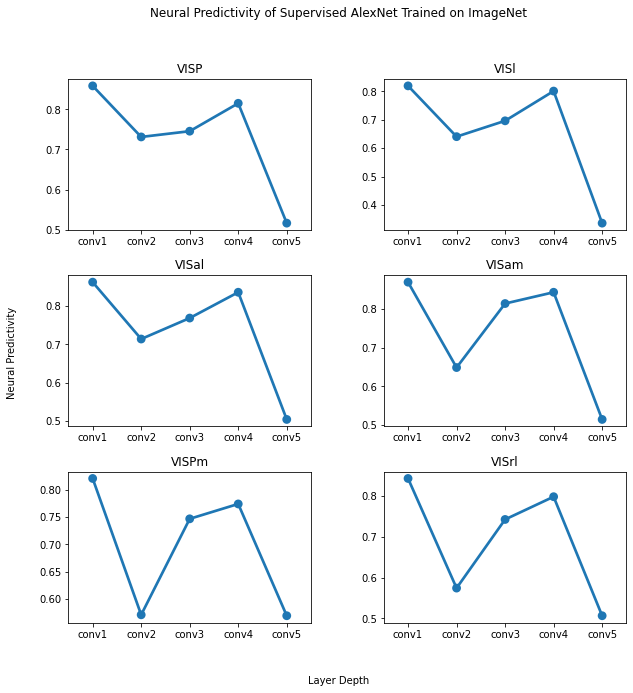

In [19]:
fig = plt.figure(facecolor="white",figsize=(10,10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
ax = fig.add_subplot(3, 2, 1)
sns.pointplot(data=neural_predictivities_supervised['VISp']).set(title='VISP')
ax = fig.add_subplot(3, 2, 2)
sns.pointplot(data=neural_predictivities_supervised['VISl'],ax=ax).set(title='VISl')
ax = fig.add_subplot(3, 2, 3)
sns.pointplot(data=neural_predictivities_supervised['VISal'],ax=ax).set(title='VISal')
ax = fig.add_subplot(3, 2, 4)
sns.pointplot(data=neural_predictivities_supervised['VISam'],ax=ax).set(title='VISam')
ax = fig.add_subplot(3, 2, 5)
sns.pointplot(data=neural_predictivities_supervised['VISpm'],ax=ax).set(title='VISPm')
ax = fig.add_subplot(3, 2, 6)
sns.pointplot(data=neural_predictivities_supervised['VISrl'],ax=ax).set(title='VISrl')
fig.suptitle("Neural Predictivity of Supervised AlexNet Trained on ImageNet")
fig.text(0.5, 0.04, 'Layer Depth', ha='center')
fig.text(0.04, 0.5, 'Neural Predictivity', va='center', rotation='vertical')

### Untrained

#### Calculate VISP Neural Predictivity

In [12]:
stimulus = NaturalScenes()
test_model_untrained = alexnet(pretrained = False)
neural_predictivities_untrained = {'VISp':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISl':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISal':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISam':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISpm':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISrl':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]}
                                    }

In [13]:
for i in range(1):
    print(i)
    train_stim,test_stim = torch.utils.data.random_split(stimulus,[int(118/2),int(118/2)])
    for layer,predictivities in neural_predictivities_untrained.items():
        if i <=1:
            print(layer)
        model_predictivities = model_predictivity(test_model_untrained.features,layer)
        for l,p in model_predictivities.items():
            if i <= 1:
                print(f'{l}:{p}')
            predictivities[l].append(p)

0
VISp
conv1:0.5906495375163845
conv2:0.8305543450774218
conv3:0.7463289864912284
conv4:0.8482092944390669
conv5:0.8491463691916505
VISl
conv1:0.5970373420691633
conv2:0.788001240027252
conv3:0.6629507934173654
conv4:0.8074795897579681
conv5:0.7912144878968728
VISal
conv1:0.6585963996126061
conv2:0.843811546039405
conv3:0.7794382694925597
conv4:0.8620620858361377
conv5:0.8500862036766669
VISam
conv1:0.6735236624972955
conv2:0.8662243535902392
conv3:0.7083614113352987
conv4:0.8774199984818873
conv5:0.8718767846903444
VISpm
conv1:0.5135169122373394
conv2:0.7861854589103884
conv3:0.6392946419778875
conv4:0.8059567744264599
conv5:0.8092039960400953
VISrl
conv1:0.6234392009758956
conv2:0.8237896932500179
conv3:0.7295145897849035
conv4:0.8173352685082236
conv5:0.8299514134836917


In [14]:
for l,p in neural_predictivities_untrained.items():
    neural_predictivities_untrained[l] = pd.DataFrame.from_dict(p)
neural_predictivities_untrained

{'VISp':      conv1     conv2     conv3     conv4     conv5
 0  0.59065  0.830554  0.746329  0.848209  0.849146,
 'VISl':       conv1     conv2     conv3    conv4     conv5
 0  0.597037  0.788001  0.662951  0.80748  0.791214,
 'VISal':       conv1     conv2     conv3     conv4     conv5
 0  0.658596  0.843812  0.779438  0.862062  0.850086,
 'VISam':       conv1     conv2     conv3    conv4     conv5
 0  0.673524  0.866224  0.708361  0.87742  0.871877,
 'VISpm':       conv1     conv2     conv3     conv4     conv5
 0  0.513517  0.786185  0.639295  0.805957  0.809204,
 'VISrl':       conv1    conv2     conv3     conv4     conv5
 0  0.623439  0.82379  0.729515  0.817335  0.829951}

#### Graph

Text(0.04, 0.5, 'Neural Predictivity')

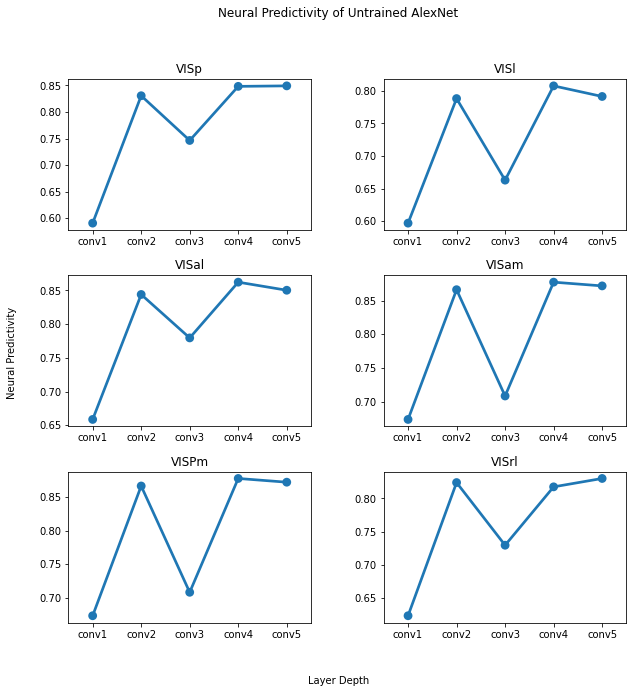

In [15]:
fig = plt.figure(facecolor="white",figsize=(10,10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
ax = fig.add_subplot(3, 2, 1)
sns.pointplot(data=neural_predictivities_untrained['VISp'],ax=ax).set(title='VISp')
ax = fig.add_subplot(3, 2, 2)
sns.pointplot(data=neural_predictivities_untrained['VISl'],ax=ax).set(title='VISl')
ax = fig.add_subplot(3, 2, 3)
sns.pointplot(data=neural_predictivities_untrained['VISal'],ax=ax).set(title='VISal')
ax = fig.add_subplot(3, 2, 4)
sns.pointplot(data=neural_predictivities_untrained['VISam'],ax=ax).set(title='VISam')
ax = fig.add_subplot(3, 2, 5)
sns.pointplot(data=neural_predictivities_untrained['VISam'],ax=ax).set(title='VISPm')
ax = fig.add_subplot(3, 2, 6)
sns.pointplot(data=neural_predictivities_untrained['VISrl'],ax=ax).set(title='VISrl')
fig.suptitle("Neural Predictivity of Untrained AlexNet")
fig.text(0.5, 0.04, 'Layer Depth', ha='center')
fig.text(0.04, 0.5, 'Neural Predictivity', va='center', rotation='vertical')